# Imbalanced Supervised Machine Learning
In this notebook, I have trained the following supervised ML models.

- Logistic Regression

- Support Vector Machine

- Random Forest

- XGBoost 

- Light GBM

- SMOTE with Random Forest

- Undersampling with Random Forest

The class distribution is 98 $\%$ majority class (non-fatal collisions) and 2 $\%$ minority class (fatal collisions). The optimizimation of the area under the receiver operating characteristic (AUROC) curve gives a slight improvement on the predictive power of the models.  SMOTE and Under Sampling techniques in combination with Random Forest classifier were applied on the training set, but they did not give any significant improvement on the imbalanced test set.

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVC
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [52]:
# Import custom classes
%run -i '../src/helper/01_transfxn.py'
%run -i '../src/helper/02_ml.py'

In [53]:
# Instantiate the classes
transfxn = TransformationPipeline()
model = SupervisedModels()

# Load data

In [4]:
df = pd.read_csv('../data/feat_engr_data.csv') # Load cleaned data
print('Data size',df.shape) # data size
df.head()

Data size (6771768, 26)


,c_case,c_year,c_mnth,c_wday,c_hour,c_vehs,c_conf,c_rcfg,c_wthr,c_rsur,...,p_sex,p_age,p_psn,p_isev,p_safe,p_user,class,count_p_isev,avg_p_age,c_conf_ind
0,752,1999,January,Monday,20.0,2.0,Right turn,NaN,Clear and sunny,Icy,...,M,41.0,Driver,No Injury,NaN,Motor Vehicle Driver,0,3,26.666667,N
1,752,1999,January,Monday,20.0,2.0,Right turn,NaN,Clear and sunny,Icy,...,M,19.0,Driver,No Injury,NaN,Motor Vehicle Driver,0,3,26.666667,N
2,752,1999,January,Monday,20.0,2.0,Right turn,NaN,Clear and sunny,Icy,...,F,20.0,"Front row, right outboard",Injury,Safety device used,Motor Vehicle Passenger,0,3,26.666667,N
3,753,1999,January,Monday,8.0,1.0,Hit a moving object,NaN,"Freezing rain, sleet, hail",Snow,...,M,46.0,Driver,No Injury,NaN,Motor Vehicle Driver,0,2,25.500000,N
4,753,1999,January,Monday,8.0,1.0,Hit a moving object,NaN,"Freezing rain, sleet, hail",Snow,...,M,5.0,Pedestrian,Injury,NaN,Pedestrian,0,2,25.500000,N


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6771768 entries, 0 to 6771767
Data columns (total 26 columns):
 #   Column        Dtype  
---  ------        -----  
 0   c_case        int64  
 1   c_year        int64  
 2   c_mnth        object 
 3   c_wday        object 
 4   c_hour        float64
 5   c_vehs        float64
 6   c_conf        object 
 7   c_rcfg        object 
 8   c_wthr        object 
 9   c_rsur        object 
 10  c_raln        object 
 11  c_traf        object 
 12  v_id          float64
 13  v_type        object 
 14  v_year        float64
 15  p_id          float64
 16  p_sex         object 
 17  p_age         float64
 18  p_psn         object 
 19  p_isev        object 
 20  p_safe        object 
 21  p_user        object 
 22  class         int64  
 23  count_p_isev  int64  
 24  avg_p_age     float64
 25  c_conf_ind    object 
dtypes: float64(7), int64(4), object(15)
memory usage: 1.3+ GB


# Class distribution

In [6]:
label_pct = df['class'].value_counts(normalize = True)*100
label_ct =  df['class'].value_counts()
pd.DataFrame(
    {
        'labels': label_pct.index, 
        'count': label_ct.values, 
        'percentage': label_pct.values,
    }
)

,labels,count,percentage
0,0,6659293,98.33906
1,1,112475,1.66094


# Descriptive statistics

In [7]:
df.drop(['class', 'p_id', 'v_id'], axis =1).describe()

,c_case,c_year,c_hour,c_vehs,v_year,p_age,count_p_isev,avg_p_age
count,6.771768e+06,6.771768e+06,6.705458e+06,6.771201e+06,6.102074e+06,6.314556e+06,6.771768e+06,6.742035e+06
mean,1.273432e+06,2.007341e+03,1.370175e+01,2.047969e+00,1.999818e+03,3.673265e+01,3.276152e+00,3.676934e+01
std,7.423571e+05,5.453024e+00,5.166753e+00,1.244772e+00,7.690798e+00,1.850699e+01,2.768235e+00,1.359288e+01
min,1.000000e+00,1.999000e+03,0.000000e+00,1.000000e+00,1.901000e+03,1.000000e+00,0.000000e+00,1.000000e+00
25%,6.262348e+05,2.003000e+03,1.000000e+01,2.000000e+00,1.995000e+03,2.200000e+01,2.000000e+00,2.625000e+01
50%,1.271344e+06,2.007000e+03,1.400000e+01,2.000000e+00,2.000000e+03,3.500000e+01,3.000000e+00,3.500000e+01
75%,1.914787e+06,2.012000e+03,1.700000e+01,2.000000e+00,2.005000e+03,5.000000e+01,4.000000e+00,4.533333e+01
max,2.570235e+06,2.017000e+03,2.300000e+01,7.700000e+01,2.018000e+03,9.900000e+01,1.230000e+02,9.900000e+01


# Reduce dataset
The dataset is very large to fit into memory, so training models on the entire dataset will take days to run let alone tuning the hyperparameters by grid search.  Hence, we will first split the dataset into two subsets and train the model on the small subset

In [8]:
X1, X2, y1, y2 = train_test_split(df, df['class'], test_size=0.0015, 
                                  random_state=42, stratify=df['class']
                                 )

In [9]:
print(f'Large subset size: {X1.shape, y1.shape}')
print(f'Small subset size: { X2.shape, y2.shape}')

Large subset size: ((6761610, 26), (6761610,))
Small subset size: ((10158, 26), (10158,))


In [10]:
# Pickle the small subset
X2.to_pickle('../data/collision.pkl')

# Use reduced dataset for machine learning

In [11]:
# Reload the small subset
df_small = pd.read_pickle('../data/collision.pkl')

In [12]:
# Feature matrix and class label
cols_to_drop = ['c_case', 'p_id', 'v_id', 'class']
X, y = df_small.drop(cols_to_drop, axis = 1), df_small['class']

In [13]:
print('Data size:', X.shape, y.shape)

Data size: (10158, 22) (10158,)


# Create a test set
We now split the data set into $80\%$ training set and $20\%$ test set in a stratify fashion

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, 
                                                    stratify=y)

In [15]:
print(f'Training set size: {X_train.shape, y_train.shape}')
print(f'Test set size: {X_test.shape, y_test.shape}')

Training set size: ((8126, 22), (8126,))
Test set size: ((2032, 22), (2032,))


In [16]:
print(f'Training set class distribution:\n {(y_train.value_counts()/X_train.shape[0])*100}')
print('--' * 15)
print(f'Test set class distribution:\n {(y_test.value_counts()/X_test.shape[0])*100}')

Training set class distribution:
 0    98.338666
1     1.661334
Name: class, dtype: float64
------------------------------
Test set class distribution:
 0    98.326772
1     1.673228
Name: class, dtype: float64


# Preprocessing
Data preprocessing involves the following steps.

- Numerical Predictors
    - Impute the missing values with the median
    - Standardize and scale the predictors
    
- Categorical Predictors
    - Impute the missing values with a constant "NA"
    - One-hot encode the predictors

In [17]:
# Preprocessing
X_train_scaled, X_test_scaled, feat_names = transfxn.preprocessing(X_train, X_test)

In [18]:
# Size of the data after pre-processing
print(f'Training set size after pre-processing: {X_train_scaled.shape}')
print(f'Test set size after pre-processing: {X_test_scaled.shape}')

Training set size after pre-processing: (8126, 150)
Test set size after pre-processing: (2032, 150)


In [19]:
# Convert the class labels to arrays
y_train, y_test = y_train.values,  y_test.values

# Model Training

## Section A-1. Logistic Regression

In [20]:
log_clf = LogisticRegression(random_state=42)  
log_clf.fit(X_train_scaled, y_train)

# Prediction on the training set
model.prediction(log_clf, X_train_scaled, y_train, 
                 subset='training set',
                 model_nm='Logistic Regression',
                )

Predictions on the training set for Logistic Regression
------------------------------------------------------------
Accuracy:  0.990893
AUC-ROC: 0.938680
AUC-PR: 0.646616
Predicted classes: [0 1]
Confusion matrix:
 [[7991    0]
 [  74   61]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      7991
           1       1.00      0.45      0.62       135

    accuracy                           0.99      8126
   macro avg       1.00      0.73      0.81      8126
weighted avg       0.99      0.99      0.99      8126

------------------------------------------------------------


## Section A-2. Cross-validation for Logistic Regression

In [21]:
model.prediction_cv(log_clf, X_train_scaled, y_train, cv_fold=10, 
                      scoring='accuracy',
                      model_nm="Logistic Regression",
                     )

10-fold cross-validation for Logistic Regression
------------------------------------------------------------
Accuracy (std): 0.990401 (0.001435)
AUC-ROC: 0.875508
AUC-PR: 0.556441
Predicted classes: [0 1]
Confusion matrix:
 [[7991    0]
 [  78   57]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      7991
           1       1.00      0.42      0.59       135

    accuracy                           0.99      8126
   macro avg       1.00      0.71      0.79      8126
weighted avg       0.99      0.99      0.99      8126

------------------------------------------------------------


## Section A-3.  Hyperparameter tuning - Logistic Regression
 In this section, we shall optimize the **AUC** of the classifiers using grid/randomized search, cross-validation, and cost sensitive method

In [22]:
# Class ratio of the 
# negative class to the positive class
neg = y_train == 0
pos = y_train == 1
class_ratio = np.sum(neg)/np.sum(pos)
class_ratio

59.19259259259259

In [23]:
# Range of hyperparameters
params = {
    'C': [2**x for x in range(-2,5,2)],
    'class_weight': ['balanced', None, {0:1, 1:class_ratio}],
}
                             
# Grid search
log_clf = LogisticRegression()   
gsearch_log = RandomizedSearchCV(estimator=log_clf, param_distributions=params, 
                                scoring='roc_auc', cv=10, n_jobs=-1, 
                                n_iter=200, random_state=42, verbose=1
                                )

# Fit the training set
gsearch_log.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(gsearch_log.best_estimator_, '../src/model/log_clf.pkl')

# Print results
print('Best AUC score:', gsearch_log.best_score_)
print('Best parameters:', gsearch_log.best_params_)    

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Best AUC score: 0.8771000649850775
Best parameters: {'class_weight': None, 'C': 1}


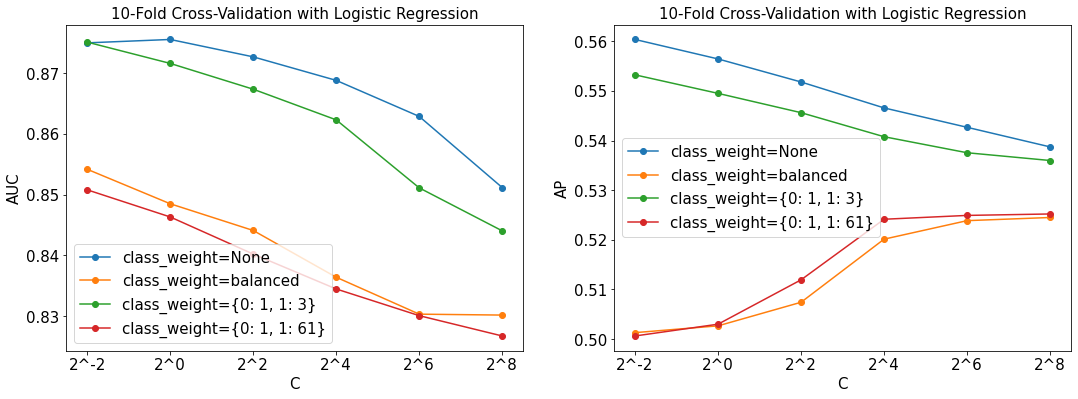

In [24]:
model.plot_auc_ap_lr(X_train_scaled, y_train, cv_fold=10)

## Section B-1. Support Vector Machine

In [25]:
svm_clf = SVC(probability=True, kernel='rbf', random_state=42)  
svm_clf.fit(X_train_scaled, y_train)

# Prediction on the training set
model.prediction(svm_clf, X_train_scaled, y_train, 
                 subset='training set',
                 model_nm='SVM Classifier',
                )

Predictions on the training set for SVM Classifier
------------------------------------------------------------
Accuracy:  0.990524
AUC-ROC: 0.998971
AUC-PR: 0.993396
Predicted classes: [0 1]
Confusion matrix:
 [[7991    0]
 [  77   58]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      7991
           1       1.00      0.43      0.60       135

    accuracy                           0.99      8126
   macro avg       1.00      0.71      0.80      8126
weighted avg       0.99      0.99      0.99      8126

------------------------------------------------------------


## Section B-2. Cross-validation for SVM

In [26]:
model.prediction_cv(svm_clf, X_train_scaled, y_train, cv_fold=10, 
                    scoring='accuracy', 
                    model_nm="SVM Classifier",
                   )

10-fold cross-validation for SVM Classifier
------------------------------------------------------------
Accuracy (std): 0.990278 (0.001285)
AUC-ROC: 0.855658
AUC-PR: 0.546691
Predicted classes: [0 1]
Confusion matrix:
 [[7991    0]
 [  79   56]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      7991
           1       1.00      0.41      0.59       135

    accuracy                           0.99      8126
   macro avg       1.00      0.71      0.79      8126
weighted avg       0.99      0.99      0.99      8126

------------------------------------------------------------


## Section B-3. Hyperparameter tuning- SVM

In [27]:
# Range of hyperparameters
params = {
    'C': [2**x for x in range(-2,8,2)], 
    'gamma': [2**x for x in range(-11,1,2)],
    'class_weight': ['balanced', None, {0:1, 1:class_ratio}],
         } 
                                                              
# Randomized search for SVM
svm_clf = SVC(probability=True, kernel='rbf')
rsearch_svm = RandomizedSearchCV(svm_clf, param_distributions=params, cv=10,
                                 scoring='roc_auc', n_iter=200,
                                 n_jobs=-1, random_state=42, verbose=1
                                ) 
# Fit the training set
rsearch_svm.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_svm.best_estimator_, '../src/model/svm_clf.pkl')

print('Best AUC score: ', rsearch_svm.best_score_)
print('Best parameters: ', rsearch_svm.best_params_)  

Fitting 10 folds for each of 90 candidates, totalling 900 fits
Best AUC score:  0.8814634433151329
Best parameters:  {'gamma': 0.125, 'class_weight': 'balanced', 'C': 0.25}


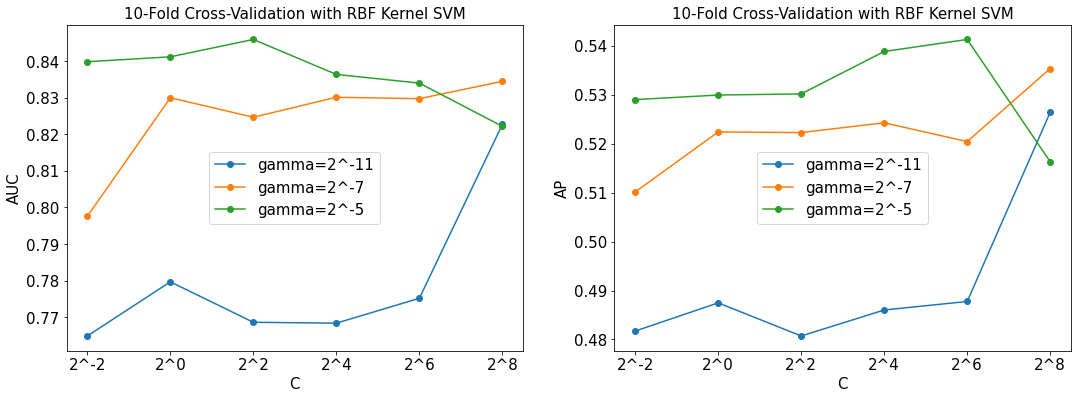

In [28]:
model.plot_auc_ap_svm(X_train_scaled, y_train, cv_fold=10, class_weight=None)

## Section C-1. Random Forest

In [29]:
rf_clf = RandomForestClassifier(random_state=42)   
rf_clf.fit(X_train_scaled, y_train)

# Prediction on the training set
model.prediction(rf_clf, X_train_scaled, y_train, 
                 subset='training set',
                 model_nm='Random Forest Classifier',
                )

Predictions on the training set for Random Forest Classifier
------------------------------------------------------------
Accuracy:  1.000000
AUC-ROC: 1.000000
AUC-PR: 1.000000
Predicted classes: [0 1]
Confusion matrix:
 [[7991    0]
 [   0  135]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7991
           1       1.00      1.00      1.00       135

    accuracy                           1.00      8126
   macro avg       1.00      1.00      1.00      8126
weighted avg       1.00      1.00      1.00      8126

------------------------------------------------------------


## Section C-2. Cross-validation for Random Forest

In [30]:
rf_clf = RandomForestClassifier(random_state = 42)                         
model.prediction_cv(rf_clf, X_train_scaled, y_train, 
                    cv_fold=10, 
                    scoring='accuracy', 
                    model_nm="Random Forest Classifier",
                   )

10-fold cross-validation for Random Forest Classifier
------------------------------------------------------------
Accuracy (std): 0.989909 (0.001632)
AUC-ROC: 0.868816
AUC-PR: 0.551278
Predicted classes: [0 1]
Confusion matrix:
 [[7991    0]
 [  82   53]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      7991
           1       1.00      0.39      0.56       135

    accuracy                           0.99      8126
   macro avg       0.99      0.70      0.78      8126
weighted avg       0.99      0.99      0.99      8126

------------------------------------------------------------


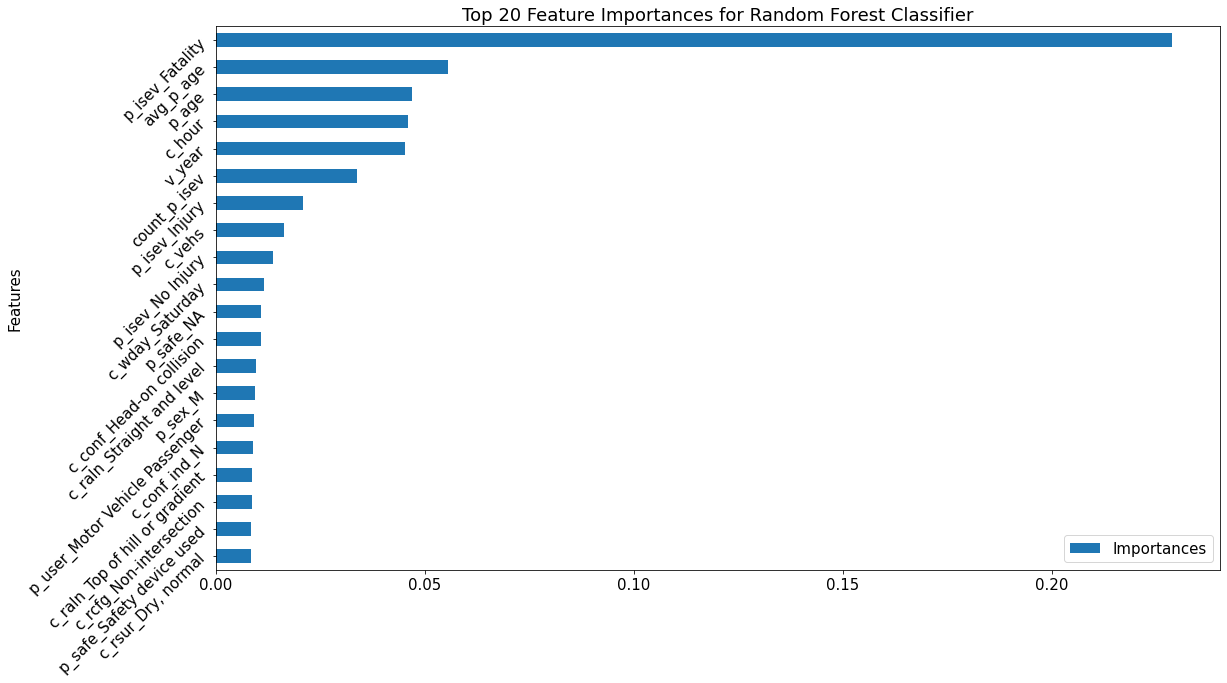

In [31]:
# Compute feature importances
importances_df = pd.DataFrame(
    {
        'Features': feat_names, 
        'Importances': rf_clf.feature_importances_,
    }
)
# Bar plot
importances_df.sort_values('Importances', ascending=True, inplace=True)
importances_df.set_index('Features', inplace=True)
importances_df.tail(20).plot(kind='barh', figsize=(18,10))
plt.yticks(rotation=45)
plt.title('Top 20 Feature Importances for Random Forest Classifier')
plt.show()

## Section C-3.  Hyperparameter tuning - Random Forest

In [32]:
# Range of hyperparameters
params = {
    'max_features': [0.5, 1, 'sqrt', 'log2', None],
    'max_depth': range(2,8,1),
    'min_samples_split': range(2,10,1),
    'class_weight': ['balanced', None, {0: 1, 1: class_ratio}],
}

# Randomized search
rf_clf = RandomForestClassifier(n_estimators=1000, random_state=42)           
rsearch_rf = RandomizedSearchCV(estimator=rf_clf, param_distributions=params, 
                                scoring='roc_auc', cv=10, n_jobs=-1, n_iter=200, 
                                random_state=42, verbose=1
                               )  
# Fit the  training set                                                    
rsearch_rf.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_rf.best_estimator_, '../src/model/rf_clf.pkl')

# Print results
print('Randomized search best AUC score:', rsearch_rf.best_score_) 
print('Randomized search best hyperparameters:', rsearch_rf.best_params_) 

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Randomized search best AUC score: 0.8889916138304749
Randomized search best hyperparameters: {'min_samples_split': 3, 'max_features': 'sqrt', 'max_depth': 7, 'class_weight': None}


## Section D-1. XGBoost

In [33]:
param_dist = {
    'objective':'binary:logistic', 
    'eval_metric':'logloss', 
    'learning_rate':0.05, 
    'random_state':42,
    'n_jobs':-1,
    'n_estimators':100,
}
              
xgb_clf = xgb.XGBClassifier(**param_dist)
xgb_clf.fit(X_train_scaled, y_train)

# Prediction on the training set
model.prediction(xgb_clf, X_train_scaled, y_train, 
                 subset='training set',
                 model_nm='XGBoost Classifier',
                )

Predictions on the training set for XGBoost Classifier
------------------------------------------------------------
Accuracy:  0.992124
AUC-ROC: 0.986726
AUC-PR: 0.854179
Predicted classes: [0 1]
Confusion matrix:
 [[7991    0]
 [  64   71]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      7991
           1       1.00      0.53      0.69       135

    accuracy                           0.99      8126
   macro avg       1.00      0.76      0.84      8126
weighted avg       0.99      0.99      0.99      8126

------------------------------------------------------------


## Section D-2: Cross-validation for XGBoost

In [34]:
model.prediction_cv(xgb_clf, X_train_scaled, y_train, 
                    cv_fold=10, scoring='accuracy',
                    model_nm="XGBoost Classifier",
                   )

10-fold cross-validation for XGBoost Classifier
------------------------------------------------------------
Accuracy (std): 0.990401 (0.001435)
AUC-ROC: 0.882654
AUC-PR: 0.551219
Predicted classes: [0 1]
Confusion matrix:
 [[7989    2]
 [  76   59]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      7991
           1       0.97      0.44      0.60       135

    accuracy                           0.99      8126
   macro avg       0.98      0.72      0.80      8126
weighted avg       0.99      0.99      0.99      8126

------------------------------------------------------------


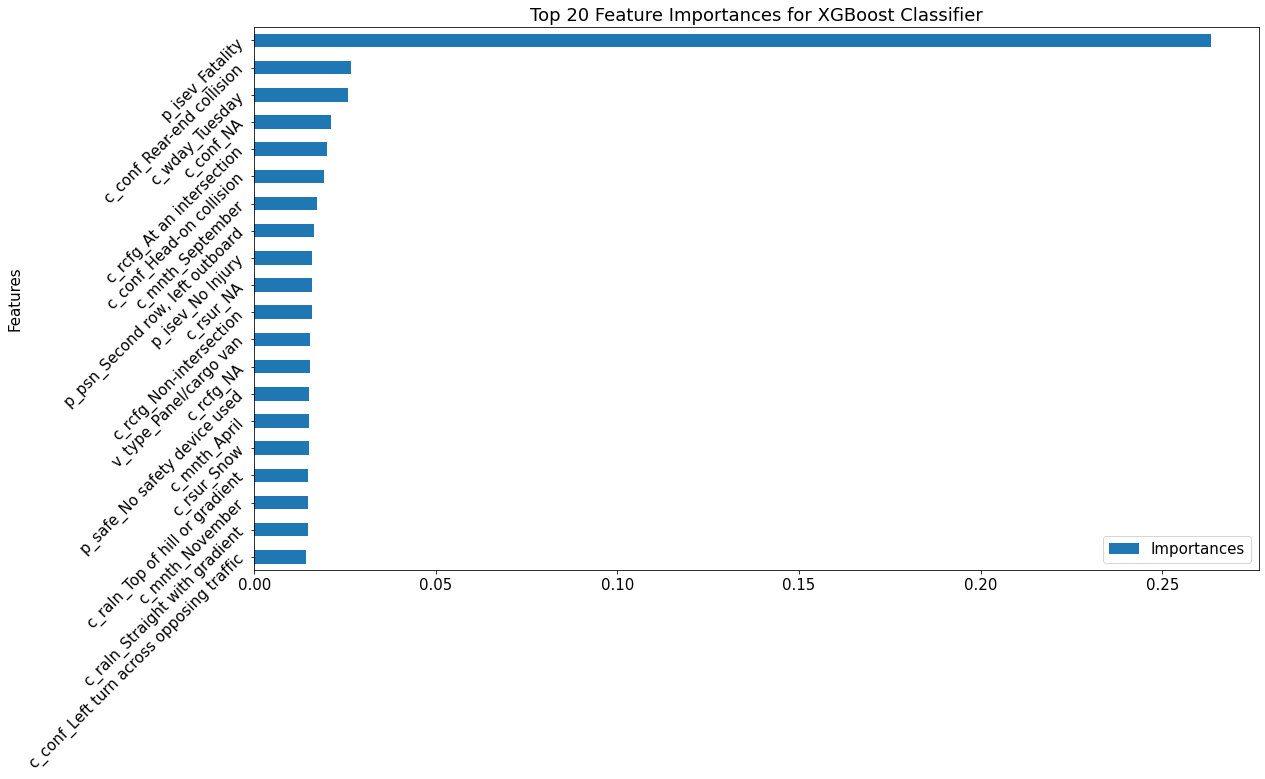

In [35]:
# Compute feature importances
importances_df = pd.DataFrame(
    {
    'Features': feat_names,
    'Importances': xgb_clf.feature_importances_,
    }
)
# Bar plot
importances_df.sort_values('Importances', ascending=True, inplace=True)
importances_df.set_index('Features', inplace=True)
importances_df.tail(20).plot(kind='barh', figsize=(18,10))
plt.yticks(rotation=45)
plt.title('Top 20 Feature Importances for XGBoost Classifier')
plt.show()

## Section D-3. Hyperparameter tuning  - XGBoost

In [36]:
# Range of hyperparameters
params = {'max_depth': range(1,10,2), 
          'min_child_weight': range(1,6,2),
          'gamma':[i/100 for i in range(0,6)],
          'subsample':[i/10 for i in range(5,9)],
          'colsample_bytree': [i/10 for i in range(5,9)],
          'learning_rate': [0.01, 0.02, 0.05, 0.1],
          }

# Randomized search
param_dist = {
    'objective':'binary:logistic', 
    'eval_metric':'logloss', 
    'n_estimators':100,
    'scale_pos_weight':class_ratio, 
    'random_state':42,
            }     
xgb_clf = xgb.XGBClassifier(**param_dist)
rsearch_xgb = RandomizedSearchCV(estimator=xgb_clf, param_distributions=params, 
                                  scoring='roc_auc', cv=10, n_jobs=-1, n_iter=200, 
                                  random_state=42, verbose=1
                                )   
# Fit the  training set                                                            
rsearch_xgb.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_xgb.best_estimator_, '../src/model/xgb_clf.pkl')

# Print results
print('Randomized search best AUC score:', rsearch_xgb.best_score_) 
print('Randomized search best hyperparameters:', rsearch_xgb.best_params_) 

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Randomized search best AUC score: 0.8949878024041041
Randomized search best hyperparameters: {'subsample': 0.5, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.0, 'colsample_bytree': 0.7}


## Section E-1. LGBM

In [37]:
param_dict = {
    'boosting_type':'gbdt', 
    'num_leaves':31, 
    'max_depth':- 1, 
    'learning_rate':0.05, 
    'n_estimators':100, 
    'random_state':42,
}
lgb_clf = lgb.LGBMClassifier(**param_dict)
lgb_clf.fit(X_train_scaled, y_train)

# Prediction on the training set
model.prediction(lgb_clf, X_train_scaled, y_train, 
                 subset='training set',
                 model_nm='LGBM Classifier',
                )

Predictions on the training set for LGBM Classifier
------------------------------------------------------------
Accuracy:  1.000000
AUC-ROC: 1.000000
AUC-PR: 1.000000
Predicted classes: [0 1]
Confusion matrix:
 [[7991    0]
 [   0  135]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7991
           1       1.00      1.00      1.00       135

    accuracy                           1.00      8126
   macro avg       1.00      1.00      1.00      8126
weighted avg       1.00      1.00      1.00      8126

------------------------------------------------------------


## Section E-2. Cross-validation for LGBM

In [38]:
model.prediction_cv(lgb_clf, X_train_scaled, y_train, 
                    cv_fold=10, 
                    model_nm='LGBM Classifier'
                   )

10-fold cross-validation for LGBM Classifier
------------------------------------------------------------
Accuracy (std): 0.990278 (0.001285)
AUC-ROC: 0.874045
AUC-PR: 0.528708
Predicted classes: [0 1]
Confusion matrix:
 [[7988    3]
 [  76   59]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      7991
           1       0.95      0.44      0.60       135

    accuracy                           0.99      8126
   macro avg       0.97      0.72      0.80      8126
weighted avg       0.99      0.99      0.99      8126

------------------------------------------------------------


Text(0.5, 1.0, 'Top 10 Feature Importances for LGBM Classifier')

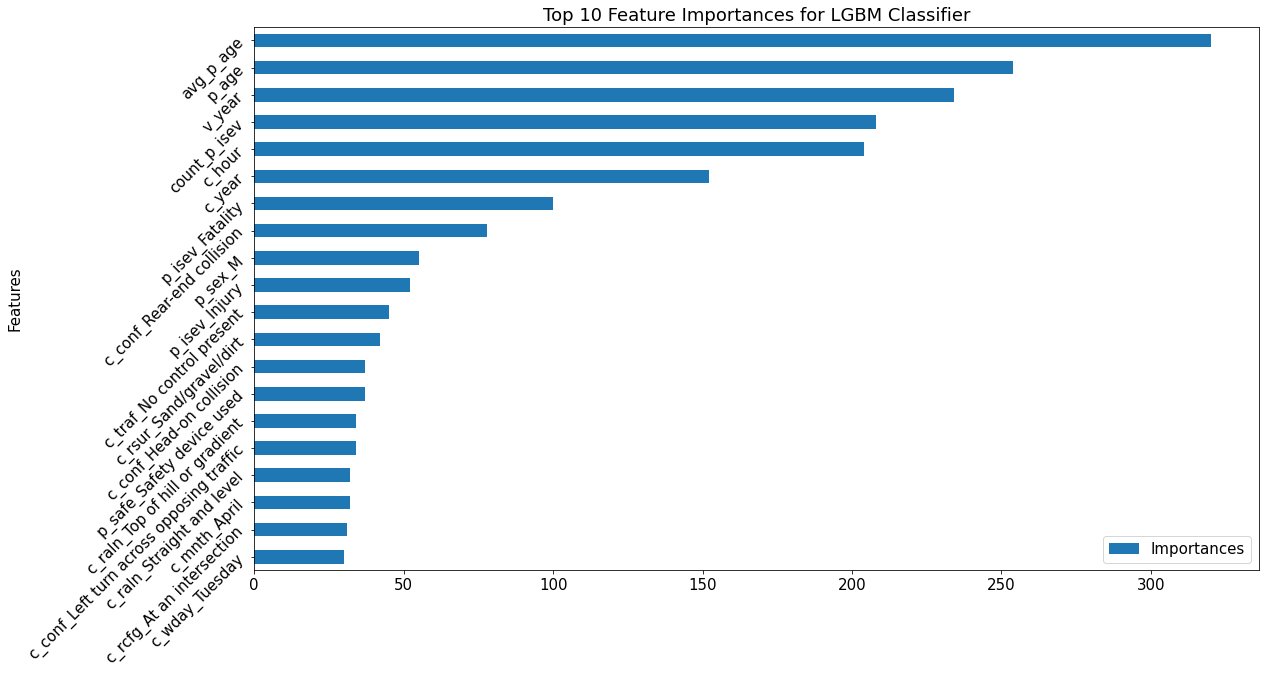

In [39]:
# Compute feature importances
importances_df = pd.DataFrame(
    {
        'Features': feat_names, 
        'Importances': lgb_clf.feature_importances_,
    }
)
# Plot
importances_df.sort_values('Importances', ascending=True, inplace=True)
importances_df.set_index('Features', inplace = True)
importances_df.tail(20).plot(kind='barh', figsize=(18,10))
plt.yticks(rotation=45)
plt.title('Top 10 Feature Importances for LGBM Classifier')
# plt.savefig('../image/lgbm.png')

## Section E-3. Hyperparameter tuning  - LGBM

In [40]:
# Hyperparameter range
params = {'max_depth': [-1,30,40],
          'num_leaves': range(80,120,10),
          'min_child_samples': range(20,50,10),
          'learning_rate': [0.01, 0.02, 0.05, 0.1],
          }

# Randomized search
param_dict = {'boosting_type':'gbdt', 
              'n_estimators':100, 
              'random_state':42,
              'scale_pos_weight':class_ratio,
             }
             
lgb_clf =  lgb.LGBMClassifier(**param_dict)                       
rsearch_lgbm = RandomizedSearchCV(estimator=lgb_clf, param_distributions=params, 
                                n_iter=200, scoring='roc_auc', cv=10, 
                                n_jobs=-1, random_state=42, verbose=1
                                 )  
# Fit model
rsearch_lgbm.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_lgbm.best_estimator_, '../src/model/lgb_clf.pkl')

# Print results
print('Randomized search best AUC score:', rsearch_lgbm.best_score_) 
print('Best hyperparameters:', rsearch_lgbm.best_params_) 

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
Randomized search best AUC score: 0.8922739714134424
Best hyperparameters: {'num_leaves': 80, 'min_child_samples': 40, 'max_depth': -1, 'learning_rate': 0.01}


In [41]:
# Load trained model
log_clf = joblib.load('../src/model/log_clf.pkl')
svm_clf = joblib.load('../src/model/svm_clf.pkl')
rf_clf = joblib.load('../src/model/rf_clf.pkl')
xgb_clf = joblib.load('../src/model/xgb_clf.pkl')
lgb_clf = joblib.load('../src/model/lgb_clf.pkl')

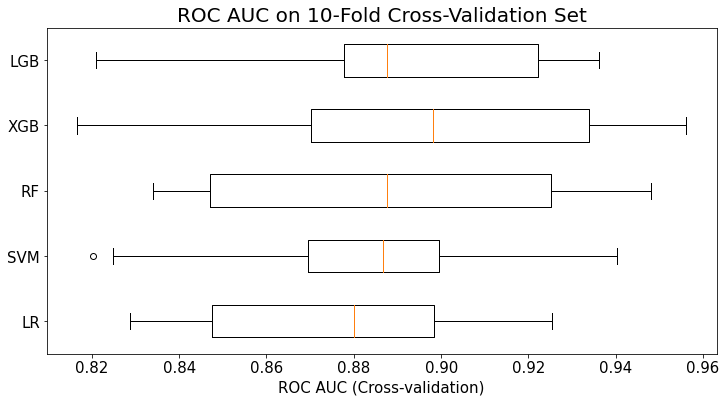

In [42]:
model_dict = {
    'LR': log_clf, 
    'SVM': svm_clf, 
    'RF': rf_clf, 
    'XGB': xgb_clf, 
    'LGB': lgb_clf,
}

roc_scores = []
for i, (name, model) in enumerate(model_dict.items()):
    score = cross_val_score(model, X_train_scaled, y_train, cv=10, scoring='roc_auc')
    roc_scores.append(score)

plt.figure(figsize=(12,6))
plt.boxplot(roc_scores, vert=False)
plt.yticks(np.arange(len(model_dict))+1, list(model_dict.keys()))
plt.title('ROC AUC on 10-Fold Cross-Validation Set', fontsize=20)
plt.xlabel('ROC AUC (Cross-validation)')
plt.savefig('../image/cv_metric.png')
plt.show()

# Section F. Resampling Methods
In this section, we will employ two resampling techniques on the training set to balance the classes. However, the final prediction will be made on the imbalanced test set. The idea of resampling is to trick the classifier using a balanced dataset.  

## Section F-1. Under Sampling  combined with Random Forest Classifier
In undersampling, we reduce the majority class such that it matches the minority class

In [43]:
# Under sample the majority class
und = RandomUnderSampler(random_state=42)
X_train_scaled_und, y_train_und = und.fit_resample(X_train_scaled, y_train)

In [44]:
print('Undersampled training data size:', X_train_scaled_und.shape, y_train_und.shape)

Undersampled training data size: (270, 150) (270,)


In [45]:
print('Imbalanced training set class distribution:', np.bincount(y_train))
print('Undersampled training set class distribution:', np.bincount(y_train_und))

Imbalanced training set class distribution: [7991  135]
Undersampled training set class distribution: [135 135]


In [54]:
param_dist = {
    'objective':'binary:logistic', 
    'eval_metric':'logloss', 
    'learning_rate':0.05, 
    'random_state':42,
    'n_jobs':-1,
    'n_estimators':100,
}
              
xgb_und = xgb.XGBClassifier(**param_dist)
xgb_und.fit(X_train_scaled_und, y_train_und)

# Prediction on the training set
model.prediction(xgb_und, X_train_scaled_und, y_train_und, 
                 subset='training set',
                 model_nm='Undersampling with XGBoost Classifier',
                )

Predictions on the training set for Undersampling with XGBoost Classifier
------------------------------------------------------------
Accuracy:  0.992593
AUC-ROC: 1.000000
AUC-PR: 1.000000
Predicted classes: [0 1]
Confusion matrix:
 [[135   0]
 [  2 133]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       135
           1       1.00      0.99      0.99       135

    accuracy                           0.99       270
   macro avg       0.99      0.99      0.99       270
weighted avg       0.99      0.99      0.99       270

------------------------------------------------------------


In [55]:
# Random Forest cross-validation on the undersampled dataset
model.prediction_cv(xgb_und, X_train_scaled_und, y_train_und, 
                    cv_fold=10, scoring='accuracy', 
                    model_nm="Undersampling with XGBoost Classifier",
                   )

10-fold cross-validation for Undersampling with XGBoost Classifier
------------------------------------------------------------
Accuracy (std): 0.829630 (0.033945)
AUC-ROC: 0.894486
AUC-PR: 0.917213
Predicted classes: [0 1]
Confusion matrix:
 [[124  11]
 [ 35 100]]
Classification report:
               precision    recall  f1-score   support

           0       0.78      0.92      0.84       135
           1       0.90      0.74      0.81       135

    accuracy                           0.83       270
   macro avg       0.84      0.83      0.83       270
weighted avg       0.84      0.83      0.83       270

------------------------------------------------------------


## Section F-2. SMOTE  combined with Random Forest Classifier
In Synthetic Minority Over Sampling Technique (SMOTE), we generate synthetic oberservations to match the minority clas.
SMOTE oversampled the minority class in the training set, so we now have equal class distribution. 

In [56]:
# Over sample the minority class
sm = SMOTE(random_state = 42)
X_train_scaled_ovsm, y_train_ovsm = sm.fit_resample(X_train_scaled, y_train)

In [57]:
print('SMOTE training data size:', X_train_scaled_ovsm.shape, y_train_ovsm.shape)

SMOTE training data size: (15982, 150) (15982,)


In [58]:
print('Imbalanced training set class distribution:', np.bincount(y_train))
print('SMOTE resampled training set class distribution:', np.bincount(y_train_ovsm))

Imbalanced training set class distribution: [7991  135]
SMOTE resampled training set class distribution: [7991 7991]


In [59]:
param_dist = {
    'objective':'binary:logistic', 
    'eval_metric':'logloss', 
    'learning_rate':0.05, 
    'random_state':42,
    'n_jobs':-1,
    'n_estimators':100,
}
              
xgb_ovsm = xgb.XGBClassifier(**param_dist)
xgb_ovsm.fit(X_train_scaled_ovsm, y_train_ovsm)

# Prediction on the training set
model.prediction(xgb_ovsm, X_train_scaled_ovsm, y_train_ovsm, 
                 subset='training set',
                 model_nm='SMOTE with XGBoost Classifier',
                )

Predictions on the training set for SMOTE with XGBoost Classifier
------------------------------------------------------------
Accuracy:  0.995495
AUC-ROC: 0.999722
AUC-PR: 0.999755
Predicted classes: [0 1]
Confusion matrix:
 [[7975   16]
 [  56 7935]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      7991
           1       1.00      0.99      1.00      7991

    accuracy                           1.00     15982
   macro avg       1.00      1.00      1.00     15982
weighted avg       1.00      1.00      1.00     15982

------------------------------------------------------------


In [60]:
# Random Forest cross-validation on the SMOTE dataset
model.prediction_cv(xgb_ovsm, X_train_scaled_ovsm, y_train_ovsm, 
                    cv_fold=10, scoring='accuracy', 
                    model_nm="SMOTE with XGBoost Classifier",
                   )

10-fold cross-validation for SMOTE with XGBoost Classifier
------------------------------------------------------------
Accuracy (std): 0.994183 (0.011853)
AUC-ROC: 0.998645
AUC-PR: 0.999005
Predicted classes: [0 1]
Confusion matrix:
 [[7966   25]
 [  68 7923]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      7991
           1       1.00      0.99      0.99      7991

    accuracy                           0.99     15982
   macro avg       0.99      0.99      0.99     15982
weighted avg       0.99      0.99      0.99     15982

------------------------------------------------------------


# Section G. Prediction on the Imbalanced Test Set 
In this section, we make our final prediction on the imbalanced dataset after training the model using the resampling techniques.

## Section G-1. Normal imbalanced model

In [61]:
model.prediction(xgb_clf, X_test_scaled, y_test,
                 subset='test set',
                 model_nm="XGBoost Classifier",
                )

Predictions on the test set for XGBoost Classifier
------------------------------------------------------------
Accuracy:  0.956201
AUC-ROC: 0.902196
AUC-PR: 0.498828
Predicted classes: [0 1]
Confusion matrix:
 [[1920   78]
 [  11   23]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98      1998
           1       0.23      0.68      0.34        34

    accuracy                           0.96      2032
   macro avg       0.61      0.82      0.66      2032
weighted avg       0.98      0.96      0.97      2032

------------------------------------------------------------


## Section G-2. Undersampled model

In [62]:
model.prediction(xgb_und, X_test_scaled, y_test,
                subset='test set',
                model_nm="UnderSampling with XGBoost Classifier",
               )

Predictions on the test set for UnderSampling with XGBoost Classifier
------------------------------------------------------------
Accuracy:  0.856791
AUC-ROC: 0.908040
AUC-PR: 0.555432
Predicted classes: [0 1]
Confusion matrix:
 [[1713  285]
 [   6   28]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.86      0.92      1998
           1       0.09      0.82      0.16        34

    accuracy                           0.86      2032
   macro avg       0.54      0.84      0.54      2032
weighted avg       0.98      0.86      0.91      2032

------------------------------------------------------------


## Section G-3. SMOTE model

In [63]:
model.prediction(xgb_ovsm, X_test_scaled, y_test,
                subset='test set',
                model_nm="SMOTE with XGBoost Classifier",
               )

Predictions on the test set for SMOTE with XGBoost Classifier
------------------------------------------------------------
Accuracy:  0.987205
AUC-ROC: 0.887329
AUC-PR: 0.567430
Predicted classes: [0 1]
Confusion matrix:
 [[1990    8]
 [  18   16]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1998
           1       0.67      0.47      0.55        34

    accuracy                           0.99      2032
   macro avg       0.83      0.73      0.77      2032
weighted avg       0.99      0.99      0.99      2032

------------------------------------------------------------


# Section H.  ROC and PR Curves

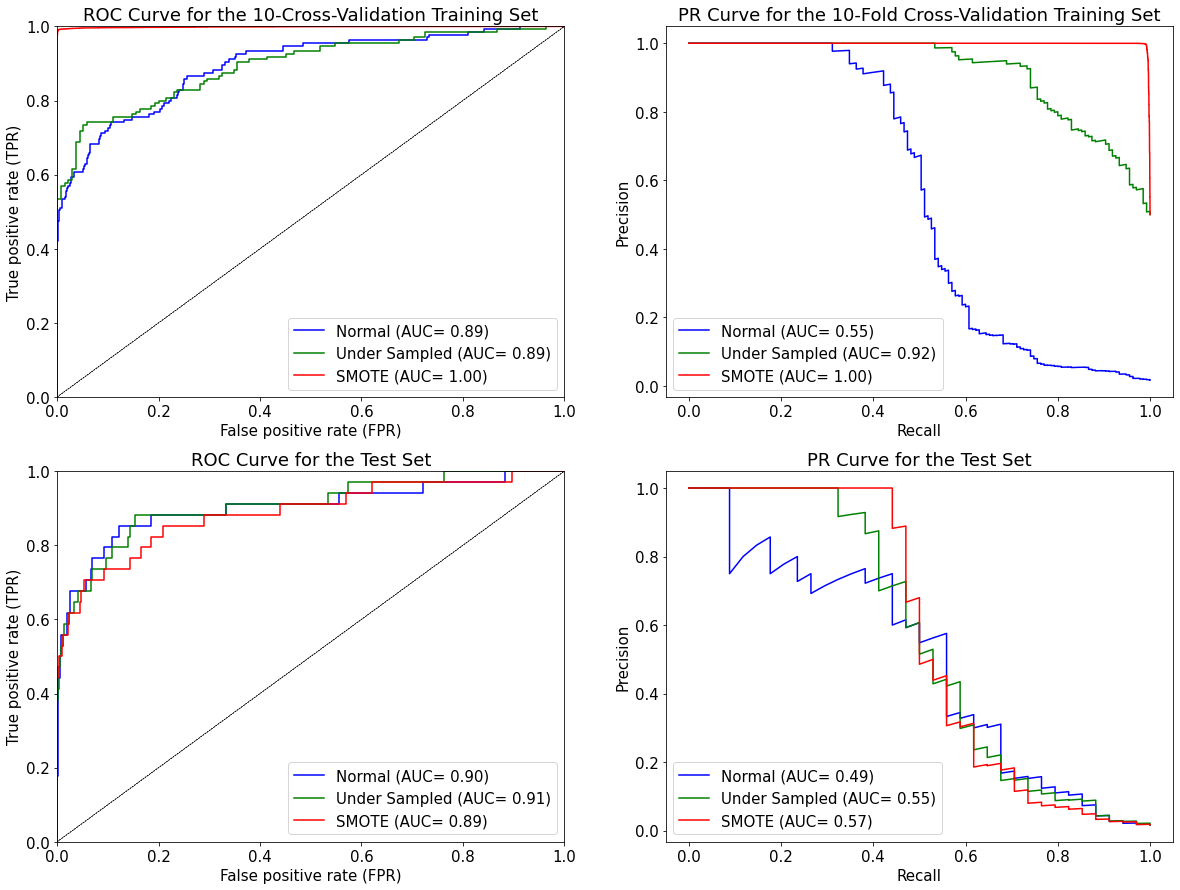

In [64]:
plt.figure(figsize=(20,15))

# Normal imbalanced distribution
model.plot_roc_pr_curves(xgb_clf, X_train_scaled, y_train, X_test_scaled, y_test, 
                         cv_fold=10, color='b', label='Normal (AUC= %0.2f)',
                        )

# Under Sampled distribution
model.plot_roc_pr_curves(xgb_und, X_train_scaled_und, y_train_und, X_test_scaled, y_test, 
                         cv_fold=10, color='g', label='Under Sampled (AUC= %0.2f)',
                        )
                     
# SMOTE distribution
model.plot_roc_pr_curves(xgb_ovsm, X_train_scaled_ovsm, y_train_ovsm, X_test_scaled, y_test, 
                         cv_fold=10, color='r', label='SMOTE (AUC= %0.2f)',
                        ) 

# Section I. AUC-ROC & AUC-PR for Cross-Validation & Test Sets

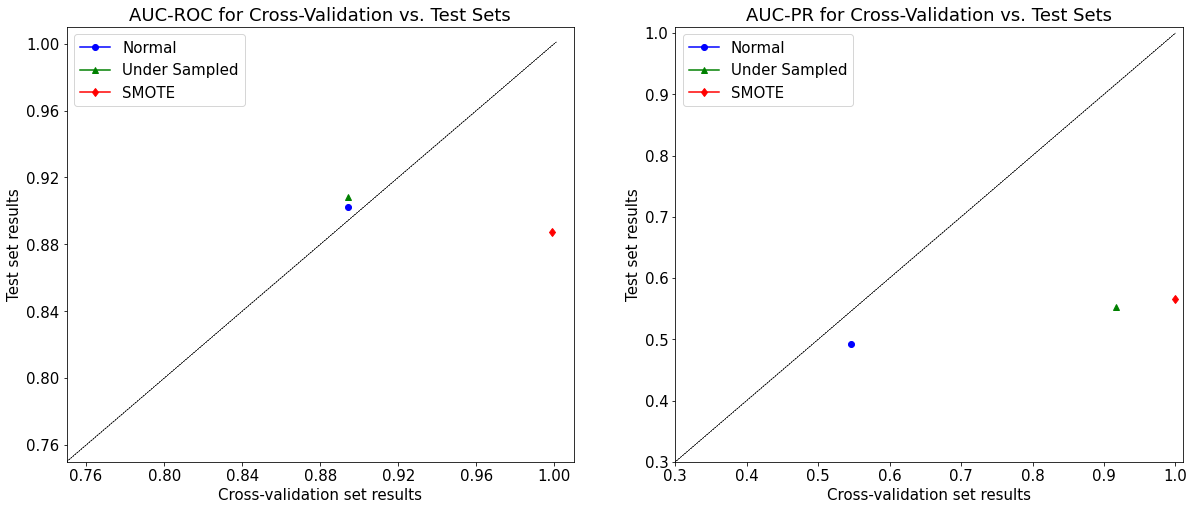

In [65]:
plt.figure(figsize=(20,8))

# Normal imbalanced distribution
model.plot_aucroc_aucpr(xgb_clf, X_train_scaled, y_train, X_test_scaled, y_test, 
                        cv_fold=10, marker='o', color='b', label='Normal',
                       )

# Under Sampled distribution
model.plot_aucroc_aucpr(xgb_und, X_train_scaled_und, y_train_und, X_test_scaled, y_test, 
                        cv_fold=10, marker='^', color='g', label='Under Sampled',
                       )
                     
# SMOTE distribution
model.plot_aucroc_aucpr(xgb_ovsm, X_train_scaled_ovsm, y_train_ovsm, X_test_scaled, y_test,
                        cv_fold=10, marker='d', color='r', label='SMOTE',
                       ) 